In [1]:
# import statements
%load_ext autoreload
%autoreload 2
%cd "../../"

import torch 
from torch.autograd import Variable 
import torch.nn as nn
import torch.optim as optim

import warnings
warnings.filterwarnings('ignore')
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    

import numpy as np
import time

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import pickle
from scipy.cluster.vq import kmeans2
import scipy.stats as ss
from scipy.io import loadmat

/m/home/home5/56/kapoorj1/unix/repos/bayesian-ode


In [105]:

# def closure():
#     return 0.5*(0.1*x*x + (y+0.5*x*x)**2)

# def prob(x, y):
#     return np.exp(-0.5*(0.1*x*x + (y+ 0.5*x*x)**2))

def closure():
    return 0.5*(0.1*(x-2)**2 + 6*(y-4)**2)

def prob(x, y):
    return 0.5*(0.1*(x-2)**2 + 6*(y-4)**2)

def plot_contours():
#     X = np.linspace(-10, 10, 300)
#     Y = np.linspace(-12, 4, 1000)
    X = np.linspace(-3, 7, 300)
    Y = np.linspace(0, 8, 1000)

    X, Y = np.meshgrid(X, Y)

    Z = prob(X, Y)
    plt.contour(X, Y, Z)

In [133]:
from samplers.metrics import *

x = torch.nn.Parameter(torch.randn([1]))
y = torch.nn.Parameter(torch.randn([1]))

params = [x, y]

def hess_closure():
    hess = eval_full_hessian(torch.autograd.grad(closure(), params, create_graph=True), params)
#     plt.figure()
#     plt.imshow(hess.clone().detach().numpy())
#     plt.colorbar()
    return hess

# metric = SoftAbsMetric(closure=hess_closure, softabs_coeff=10)
metric = HessianMetric(closure=hess_closure)
# metric = IdentityMetric(size=l)

In [134]:
from samplers import MALA, MMALA

sampler = MALA(params, lr=1e-4, add_noise=True)
# sampler = MMALA(params, metric_obj=metric, lr=1e-2)


# x.data = torch.randn([1])
# y.data = torch.randn([1])

chain, logp_array = sampler.sample(closure, burn_in=2000, num_samples=1000)


<class 'dict'>
Burn-in phase started
Burn-in iter 1
Burn-in iter 2
Burn-in iter 3
Burn-in iter 4
Burn-in iter 5
Burn-in iter 6
Burn-in iter 7
Burn-in iter 8
Burn-in iter 9
Burn-in iter 10
Burn-in iter 11
Burn-in iter 12
Burn-in iter 13
Burn-in iter 14
Burn-in iter 15
Burn-in iter 16
Burn-in iter 17
Burn-in iter 18
Burn-in iter 19
Burn-in iter 20
Burn-in iter 21
Burn-in iter 22
Burn-in iter 23
Burn-in iter 24
Burn-in iter 25
Burn-in iter 26
Burn-in iter 27
Burn-in iter 28
Burn-in iter 29
Burn-in iter 30
Burn-in iter 31
Burn-in iter 32
Burn-in iter 33
Burn-in iter 34
Burn-in iter 35
Burn-in iter 36
Burn-in iter 37
Burn-in iter 38
Burn-in iter 39
Burn-in iter 40
Burn-in iter 41
Burn-in iter 42
Burn-in iter 43
Burn-in iter 44
Burn-in iter 45
Burn-in iter 46
Burn-in iter 47
Burn-in iter 48
Burn-in iter 49
Burn-in iter 50
Burn-in iter 51
Burn-in iter 52
Burn-in iter 53
Burn-in iter 54
Burn-in iter 55
Burn-in iter 56
Burn-in iter 57
Burn-in iter 58
Burn-in iter 59
Burn-in iter 60
Burn-in iter

Burn-in iter 539
Burn-in iter 540
Burn-in iter 541
Burn-in iter 542
Burn-in iter 543
Burn-in iter 544
Burn-in iter 545
Burn-in iter 546
Burn-in iter 547
Burn-in iter 548
Burn-in iter 549
Burn-in iter 550
Burn-in iter 551
Burn-in iter 552
Burn-in iter 553
Burn-in iter 554
Burn-in iter 555
Burn-in iter 556
Burn-in iter 557
Burn-in iter 558
Burn-in iter 559
Burn-in iter 560
Burn-in iter 561
Burn-in iter 562
Burn-in iter 563
Burn-in iter 564
Burn-in iter 565
Burn-in iter 566
Burn-in iter 567
Burn-in iter 568
Burn-in iter 569
Burn-in iter 570
Burn-in iter 571
Burn-in iter 572
Burn-in iter 573
Burn-in iter 574
Burn-in iter 575
Burn-in iter 576
Burn-in iter 577
Burn-in iter 578
Burn-in iter 579
Burn-in iter 580
Burn-in iter 581
Burn-in iter 582
Burn-in iter 583
Burn-in iter 584
Burn-in iter 585
Burn-in iter 586
Burn-in iter 587
Burn-in iter 588
Burn-in iter 589
Burn-in iter 590
Burn-in iter 591
Burn-in iter 592
Burn-in iter 593
Burn-in iter 594
Burn-in iter 595
Burn-in iter 596
Burn-in iter 5

Burn-in iter 1080
Burn-in iter 1081
Burn-in iter 1082
Burn-in iter 1083
Burn-in iter 1084
Burn-in iter 1085
Burn-in iter 1086
Burn-in iter 1087
Burn-in iter 1088
Burn-in iter 1089
Burn-in iter 1090
Burn-in iter 1091
Burn-in iter 1092
Burn-in iter 1093
Burn-in iter 1094
Burn-in iter 1095
Burn-in iter 1096
Burn-in iter 1097
Burn-in iter 1098
Burn-in iter 1099
Burn-in iter 1100
Burn-in iter 1101
Burn-in iter 1102
Burn-in iter 1103
Burn-in iter 1104
Burn-in iter 1105
Burn-in iter 1106
Burn-in iter 1107
Burn-in iter 1108
Burn-in iter 1109
Burn-in iter 1110
Burn-in iter 1111
Burn-in iter 1112
Burn-in iter 1113
Burn-in iter 1114
Burn-in iter 1115
Burn-in iter 1116
Burn-in iter 1117
Burn-in iter 1118
Burn-in iter 1119
Burn-in iter 1120
Burn-in iter 1121
Burn-in iter 1122
Burn-in iter 1123
Burn-in iter 1124
Burn-in iter 1125
Burn-in iter 1126
Burn-in iter 1127
Burn-in iter 1128
Burn-in iter 1129
Burn-in iter 1130
Burn-in iter 1131
Burn-in iter 1132
Burn-in iter 1133
Burn-in iter 1134
Burn-in it

Burn-in iter 1589
Burn-in iter 1590
Burn-in iter 1591
Burn-in iter 1592
Burn-in iter 1593
Burn-in iter 1594
Burn-in iter 1595
Burn-in iter 1596
Burn-in iter 1597
Burn-in iter 1598
Burn-in iter 1599
Burn-in iter 1600
Burn-in iter 1601
Burn-in iter 1602
Burn-in iter 1603
Burn-in iter 1604
Burn-in iter 1605
Burn-in iter 1606
Burn-in iter 1607
Burn-in iter 1608
Burn-in iter 1609
Burn-in iter 1610
Burn-in iter 1611
Burn-in iter 1612
Burn-in iter 1613
Burn-in iter 1614
Burn-in iter 1615
Burn-in iter 1616
Burn-in iter 1617
Burn-in iter 1618
Burn-in iter 1619
Burn-in iter 1620
Burn-in iter 1621
Burn-in iter 1622
Burn-in iter 1623
Burn-in iter 1624
Burn-in iter 1625
Burn-in iter 1626
Burn-in iter 1627
Burn-in iter 1628
Burn-in iter 1629
Burn-in iter 1630
Burn-in iter 1631
Burn-in iter 1632
Burn-in iter 1633
Burn-in iter 1634
Burn-in iter 1635
Burn-in iter 1636
Burn-in iter 1637
Burn-in iter 1638
Burn-in iter 1639
Burn-in iter 1640
Burn-in iter 1641
Burn-in iter 1642
Burn-in iter 1643
Burn-in it

Sample iter: 104
Sample iter: 105
Sample iter: 106
Sample iter: 107
Sample iter: 108
Sample iter: 109
Sample iter: 110
Sample iter: 111
Sample iter: 112
Sample iter: 113
Sample iter: 114
Sample iter: 115
Sample iter: 116
Sample iter: 117
Sample iter: 118
Sample iter: 119
Sample iter: 120
Sample iter: 121
Sample iter: 122
Sample iter: 123
Sample iter: 124
Sample iter: 125
Sample iter: 126
Sample iter: 127
Sample iter: 128
Sample iter: 129
Sample iter: 130
Sample iter: 131
Sample iter: 132
Sample iter: 133
Sample iter: 134
Sample iter: 135
Sample iter: 136
Sample iter: 137
Sample iter: 138
Sample iter: 139
Sample iter: 140
Sample iter: 141
Sample iter: 142
Sample iter: 143
Sample iter: 144
Sample iter: 145
Sample iter: 146
Sample iter: 147
Sample iter: 148
Sample iter: 149
Sample iter: 150
Sample iter: 151
Sample iter: 152
Sample iter: 153
Sample iter: 154
Sample iter: 155
Sample iter: 156
Sample iter: 157
Sample iter: 158
Sample iter: 159
Sample iter: 160
Sample iter: 161
Sample iter: 1

Sample iter: 660
Sample iter: 661
Sample iter: 662
Sample iter: 663
Sample iter: 664
Sample iter: 665
Sample iter: 666
Sample iter: 667
Sample iter: 668
Sample iter: 669
Sample iter: 670
Sample iter: 671
Sample iter: 672
Sample iter: 673
Sample iter: 674
Sample iter: 675
Sample iter: 676
Sample iter: 677
Sample iter: 678
Sample iter: 679
Sample iter: 680
Sample iter: 681
Sample iter: 682
Sample iter: 683
Sample iter: 684
Sample iter: 685
Sample iter: 686
Sample iter: 687
Sample iter: 688
Sample iter: 689
Sample iter: 690
Sample iter: 691
Sample iter: 692
Sample iter: 693
Sample iter: 694
Sample iter: 695
Sample iter: 696
Sample iter: 697
Sample iter: 698
Sample iter: 699
Sample iter: 700
Sample iter: 701
Sample iter: 702
Sample iter: 703
Sample iter: 704
Sample iter: 705
Sample iter: 706
Sample iter: 707
Sample iter: 708
Sample iter: 709
Sample iter: 710
Sample iter: 711
Sample iter: 712
Sample iter: 713
Sample iter: 714
Sample iter: 715
Sample iter: 716
Sample iter: 717
Sample iter: 7

x_mean=-1.4737684726715088, y_mean=3.393479824066162


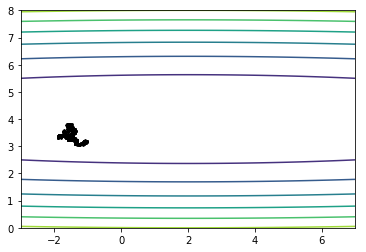

In [135]:

plot_contours()
for sample, acc in chain:
    if acc:
#         print(sample)
#         print(x, y)
        x, y = sample[0][0][0], sample[0][1][0]
        plt.scatter(x, y, color='k', s=3)

# printing means
x_mean = np.mean([sample[0][0][0] for sample, acc in chain if acc])
y_mean = np.mean([sample[0][1][0] for sample, acc in chain if acc]) 
print('x_mean={}, y_mean={}'.format(x_mean, y_mean))